## Batch Mode
Steps: (for any particular character)
1. Load Hanzi data
    a. For each stroke determine type and position
2. Load character image
3. Convert each stroke from Hanzi format to Arial format
4. Map each Arial stroke based on character image (various methods could work, anchor points is current best)
5. Readjust if needed
6. Save to data folder.

Note currently the geometry we're using is origin is top-left corner and max dimensions would be bottom right.

In [2]:
character = '\u4f4e'
print(character)

低


## Load Hanzi Character

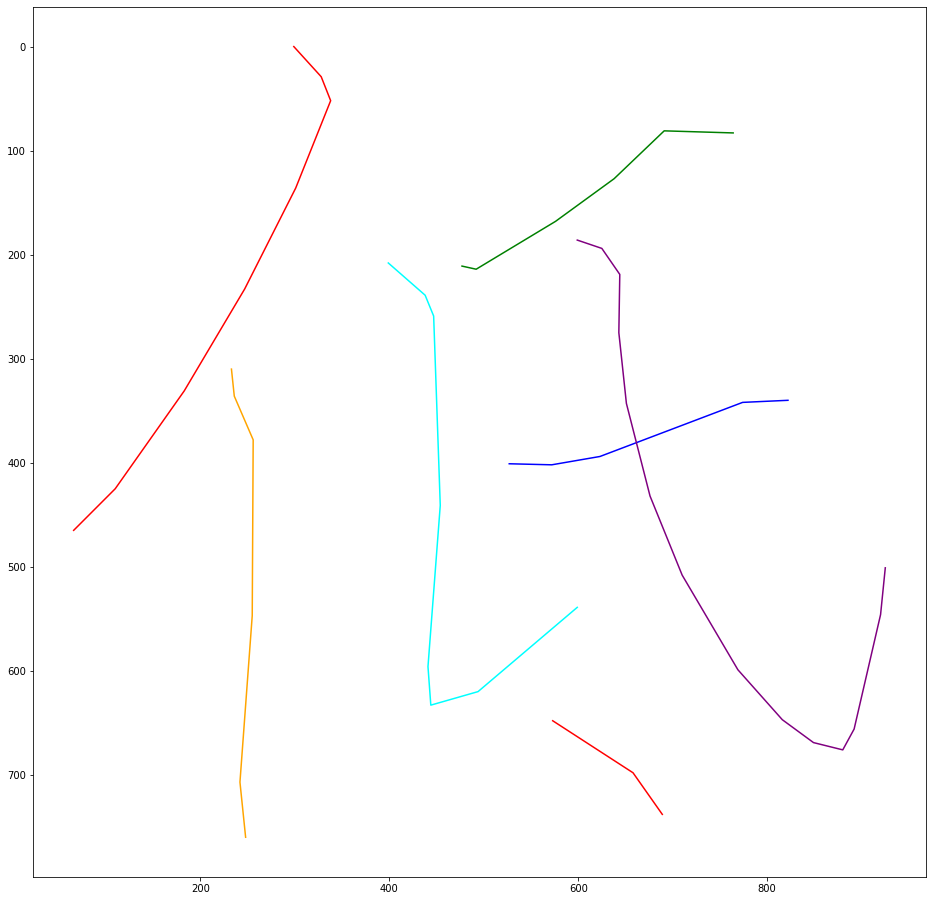

In [3]:
import json
import matplotlib.pyplot as plt
def readHanziChar(character):
    fileName = '../Data/Hanzi Data/' + character + '.json'
    with open(fileName, 'r') as f:
        charData = json.load(f)
    return charData

def plotHanziChar(charData):
    maxY = 0 #used for reversing y dim
    for stroke in charData['medians']:
        for point in stroke:
            maxY = max(maxY, point[1])
    
    colors=["red","orange","green","cyan","blue","purple"]
    i = 0
    fig, ax = plt.subplots(figsize=(16,16))
    ax.invert_yaxis()
    for stroke in charData['medians']:
        pointData = [[],[]] #[xPoints, yPoints]
        for point in stroke:
            pointData[0].append(point[0])
            pointData[1].append(maxY - point[1])
        ax.plot(pointData[0], pointData[1], color=colors[i%len(colors)]) #flips y axis
        i=i+1 #for color
    return maxY

charData = readHanziChar(character)
maxY = plotHanziChar(charData)

## Load stroke data

In [13]:
import os
from StrokeDef import StrokeType
import StrokeDef as sd
import numpy as np
import bezier

os.listdir("../Data/Strokes")

allStrokes = []
for fileName in os.listdir("../Data/Strokes"):
    allStrokes.append(sd.loadStroke(fileName, extension=""))

In [7]:
#function for calculating error for matching strokes
def pointDist(coord1, coord2): #coord = [x,y]
    return np.sqrt((coord2[1] - coord1[1])**2 + (coord2[0] - coord1[0])**2)

def getPointsHanzi(stroke, count): #get certain amount of evenly spaced points from hanzi line data
    stroke = np.array(stroke)
    totalLineDistance = 0
    incrDist = [0]
    for i in range(1, len(stroke)):
        totalLineDistance += pointDist(stroke[i-1], stroke[i])
        incrDist.append(totalLineDistance)
    segDist = (totalLineDistance / (count-1)) #-1 since we can use orgin and end as points on the line
    
    samplePoints = [stroke[0]] #start with first point
    currSeg = 0 #currSeg 0 is the first line on the graph, len(stroke)-2 is the last
    for i in range(1,count-1): #we already have the first point in, don't do the final point
        goalDist = segDist*i
        while(goalDist > incrDist[currSeg+1]): #move on to the correct segment
            currSeg += 1
        goalDist -= incrDist[currSeg] #how much further we need to go for this segment
        #figure out what frac of this segment we need to move to get our point
        fracDist = goalDist/(incrDist[currSeg+1]-incrDist[currSeg])
        samplePoints.append(stroke[currSeg] + fracDist*(stroke[currSeg+1] - stroke[currSeg]))
    samplePoints.append(stroke[-1]) #final sample point
    return np.array(samplePoints)

#bezier curves are harder so just turn them into a ton of line segments and then run the hanzi version
#note a stroke should be continuous (it shouldn't have a grap)
def getPointsBezier(stroke, count, resol=100): #get certain amount of evenly spaced points from the formal
    evalPoints = np.linspace(0.0, 1.0, resol) #start, end, resol, parametric t values
    allLinePoints = [] #each begin/end of a line segment
    for curve in stroke:
        nodes = np.array(curve).transpose()
        curve = bezier.Curve(nodes, degree=len(curve)-1)
        curvePoints = np.array(curve.evaluate_multi(evalPoints).transpose().tolist()) #[[x,y]...]
        allLinePoints.extend(curvePoints)
    return getPointsHanzi(allLinePoints, count) #we've simplified our curve to many segments

#get the error for the stroke
#each hanzi point nearest distance to formal stroke all summed
#and vice versa is the total error
def getLineErrors(hanziStroke, formalStroke, resol=200):
    hanziSample = getPointsHanzi(manualStroke, resol)
    bezierSample = getPointsBezier(formalStroke, resol, resol=100)
    
    totalError = 0
    for point in hanziSample:
        totalError += getNearestDist(point, bezierSample)
    for point in bezierSample:
        totalError += getNearestDist(point, hanziSample)
    return totalError
    
#find the nearest distance from the point to a line point
def getNearestDist(point, linePoints):
    minDist = 10e10 #arbitrary large value
    for p in linePoints:
        dist = pointDist(point, p)
        if(dist < minDist):
            minDist = dist
    return minDist

In [39]:
#a fit consists of a stroke name and bound box,
class Fit:
    def __init__(self, name, xRange, yRange):
        self.name = name
        self.x = xRange
        self.y = yRange
        
    def __str__(self):
        return (f"Stroke type {self.name}. x bounds: {self.x}, y bounds: {self.y}.")

Stroke type C0. x bounds: [66, 465], y bounds: [0, 465].
Stroke type D1. x bounds: [120.5, 760], y bounds: [310, 760].
Stroke type C0. x bounds: [477, 214], y bounds: [81, 214].
Stroke type C4. x bounds: [399, 633], y bounds: [208, 633].
Stroke type D0. x bounds: [527, 475.75], y bounds: [266.25, 475.75].
Stroke type C4. x bounds: [599, 676], y bounds: [186, 676].
Stroke type D0. x bounds: [573, 738], y bounds: [648, 738].


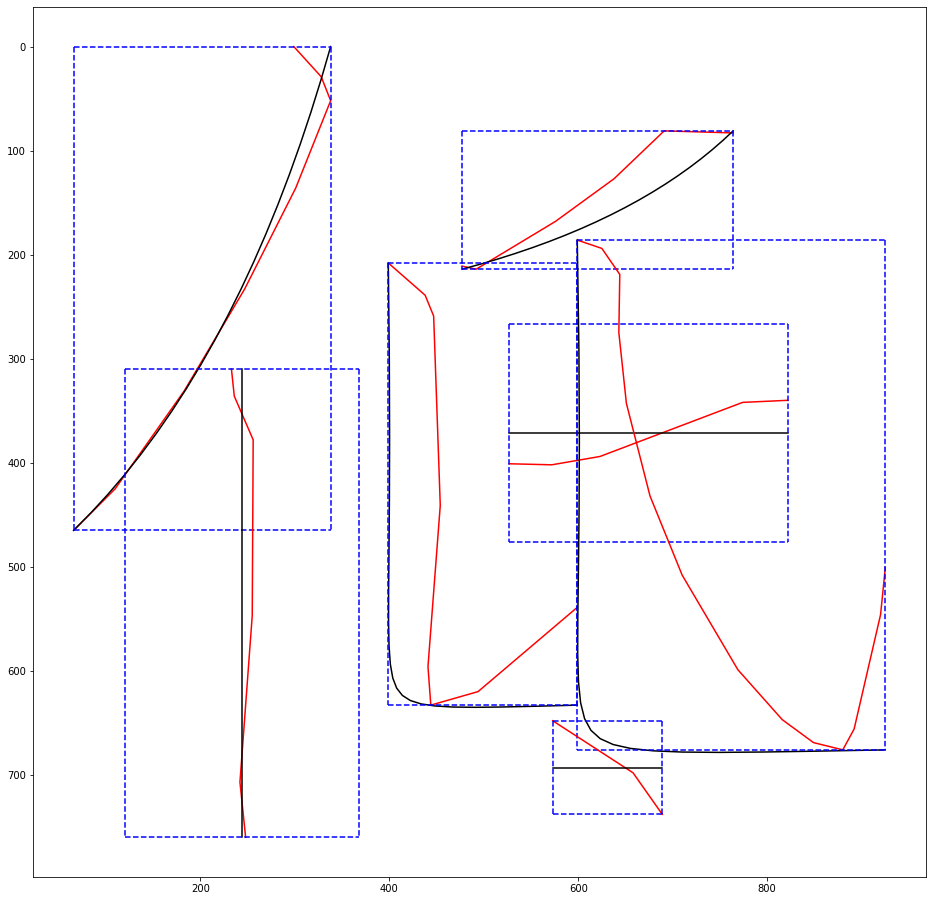

In [40]:
import numpy as np
import bezier
import matplotlib.pyplot as plt

maxYCoord = 0 #used for inverting y axis
for stroke in charData['medians']:
    for point in stroke:
        maxYCoord = max(maxYCoord, point[1])

resol = 20
evalPoints = np.linspace(0.0, 1.0, resol) #start, end, resol, parametric t values

#just for visualizing see the strokes aligned over this one strok
fig, ax = plt.subplots(figsize=(16,16))
ax.invert_yaxis()

fits = []
for manualStroke in charData['medians']: #guess correct stroke for each manual stroke
    manualStroke = np.array(manualStroke)
    manualStroke[:,1] = maxYCoord - manualStroke[:,1] #invert y coordinates 
    
    ax.plot(manualStroke[:,0], manualStroke[:,1], color='red')
    
    minX = min(manualStroke[:,0])
    maxX = max(manualStroke[:,0])
    minY = min(manualStroke[:,1])
    maxY = max(manualStroke[:,1])
    #if window is really narrow miden this, as it is clearly a horizontal or vertical line
    if((maxX - minX) < .25*(maxY - minY)): #4:1 aspect ratio, widen the x dir, make at least #4:3
        maxX += .25*(maxY - minY) 
        minX -= .25*(maxY - minY) 
    if((maxY - minY) < .25*(maxX - minX)): #4:1 aspect ratio, widen the y dir, make at least #4:3
        maxY += .25*(maxX - minX) 
        minY -= .25*(maxX - minX) 

    #print(minX,minY,maxX,maxY)
    #ax.set_ylim([minY,maxY])
    #ax.set_xlim([minX,maxX])
    
    bestStroke = None #default val
    bestType = "None"
    bestError = 10e20 #arbitrary large value
    for strokeType in allStrokes:
        strokeData = np.array(strokeType.hanzi)
        strokeData[:,:,0] = minX + (strokeData[:,:,0]*(maxX-minX))
        strokeData[:,:,1] = minY + (strokeData[:,:,1]*(maxY-minY))

        #now we compare manualStroke and the strokeData
        distError = getLineErrors(manualStroke, strokeData, resol=100)
        if(distError < bestError): #new best
            bestError = distError
            bestStroke = strokeData
            bestType = strokeType.name
        #print(distError)
    fits.append(Fit(bestType, [minX, maxY], [minY, maxY]))
    #we have found best stroke, graph it
    for curve in bestStroke: #control points, 
            nodes = np.array(curve).transpose()
            curve = bezier.Curve(nodes, degree=len(curve)-1)
            curvePoints = np.array(curve.evaluate_multi(evalPoints).transpose().tolist()) #[[x,y]...]
            ax.plot(curvePoints[:,0], curvePoints[:,1], color="black")
            
            #plot the border box too
            ax.plot([minX,minX],[minY,maxY], linestyle="dashed", color="blue")
            ax.plot([maxX,maxX],[minY,maxY], linestyle="dashed", color="blue")
            ax.plot([minX,maxX],[maxY,maxY], linestyle="dashed", color="blue")
            ax.plot([minX,maxX],[minY,minY], linestyle="dashed", color="blue")

for fit in fits:
    print(fit)